**Monte Carlo simulation for future stock prices: risk and return estimation** (candidate project for Master thesis)


Daily  S&P500 data. Source: http://investing.com/indices/us-spx-500-historical-data
Time frame: Jan 20, 2023 to June 20, 2025


In [19]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

df = pd.read_csv('stockdata.csv')  # Reading the S&P500 dataset
print(df.head())  # Displaying the first few rows of the S&P500 dataset

         Date     Price      Open      High       Low  Vol. Change %
0  06/20/2025  5,967.84  5,999.67  6,018.20  5,952.56   NaN   -0.22%
1  06/18/2025  5,980.87  5,987.93  6,018.25  5,971.89   NaN   -0.03%
2  06/17/2025  5,982.72  6,012.15  6,023.25  5,974.80   NaN   -0.84%
3  06/16/2025  6,033.11  6,004.00  6,050.83  6,004.00   NaN    0.94%
4  06/13/2025  5,976.97  6,000.56  6,026.16  5,963.21   NaN   -1.13%


In [22]:
# Clean Data: Keep 'Date' and 'Price'
df = df[['Date', 'Price']]
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Convert 'Price' to numeric (remove commas and convert to float)
df['Price'] = df['Price'].str.replace(',', '').astype(float)

# Calculate Daily Log Returns
df['Log Return'] = np.log(df['Price'] / df['Price'].shift(1))
df = df.dropna()

print(df.head())  # Displaying the first few rows of the cleaned dataset

          Date    Price  Log Return
604 2023-01-23  4019.81    0.011811
603 2023-01-24  4016.95   -0.000712
602 2023-01-25  4016.22   -0.000182
601 2023-01-26  4060.43    0.010948
600 2023-01-27  4070.56    0.002492


In [24]:
mu = df['Log Return'].mean()           # Average daily return
sigma = df['Log Return'].std()         # Standard deviation (volatility)
print(f'Mean Daily Return: {mu}')
print(f'Daily Volatility: {sigma}')

Mean Daily Return: 0.0006542225414871261
Daily Volatility: 0.00992288201996217


In [26]:
# Monte Carlo Simulation Setup
# Parameters
num_simulations = 1000  # Number of paths
num_days = 252          # 1 year = 252 trading days
last_price = df['Price'].iloc[-1] # Last known price

# Empty array to store simulations
simulations = np.zeros((num_simulations, num_days))

# Simulation Loop
for i in range(num_simulations):
    prices = [last_price]
    for d in range(1, num_days):
        # Random shock from normal distribution
        shock = np.random.normal(loc=mu, scale=sigma)
        # Simulate next price
        price = prices[-1] * np.exp(shock)
        prices.append(price)
    simulations[i, :] = prices

Simulation Loop:

For each simulation: Start with the last known price.
For each day: Generate a random daily return (shock) from a normal distribution with mean $\mu$ and standard deviation $\sigma$.
Calculate the next price using geometric Brownian motion: 

$$
S_{t+1} = S_t \times e^{\left(\mu - \frac{1}{2}\sigma^2\right)\Delta t + \sigma \epsilon \sqrt{\Delta t}}
$$

Where:

- $S_t$ = Stock price at time $t$
- $\mu$ = Mean (expected return per time step)
- $\sigma$ = Volatility (standard deviation of returns per time step)
- $\epsilon$ = Random draw from the standard normal distribution
- $\Delta t$ = Time step (1 day = $1/252$)

This formula is used in each step of the simulation to generate possible future price paths.
</VSCode.Cell>

next_price = previous_price * exp(shock)  
Append the new price to the path.
Store the simulated path in the simulations array.

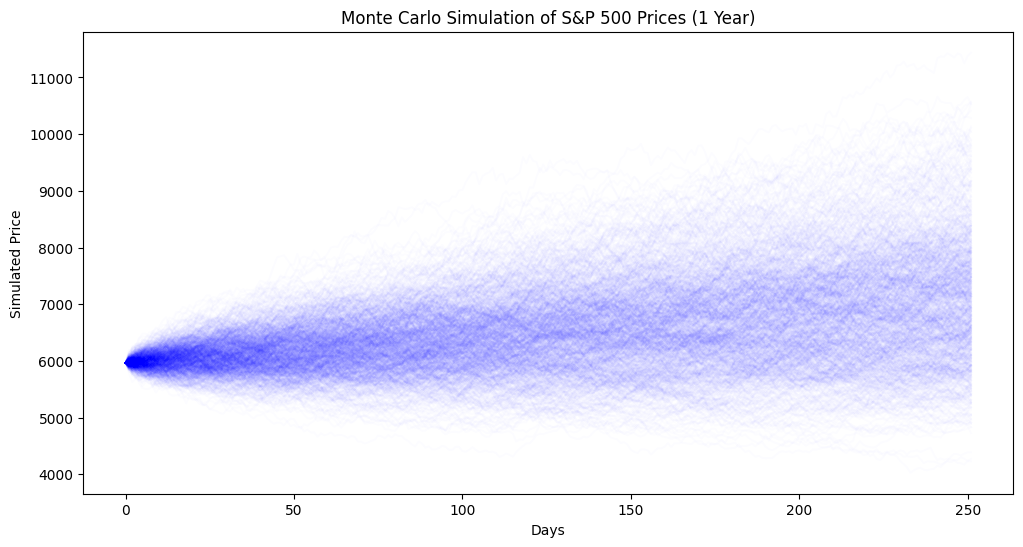

In [27]:
plt.figure(figsize=(12,6))
for i in range(num_simulations):
    plt.plot(simulations[i, :], color='blue', alpha=0.01)

plt.title('Monte Carlo Simulation of S&P 500 Prices (1 Year)')
plt.xlabel('Days')
plt.ylabel('Simulated Price')
plt.show()

In [28]:
# 🎯 Calculate 95% Confidence Interval for Final Price
final_prices = simulations[:, -1]
ci_lower = np.percentile(final_prices, 2.5)
ci_upper = np.percentile(final_prices, 97.5)

print(f'95% Confidence Interval for Final Price: {ci_lower:.2f} - {ci_upper:.2f}')

95% Confidence Interval for Final Price: 5186.88 - 9616.55


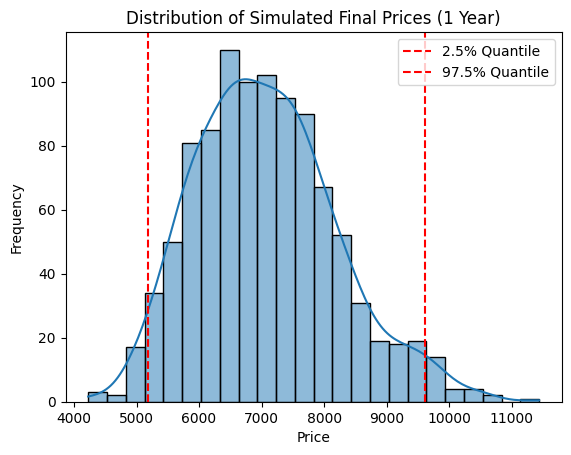

In [29]:
# Plot Distribution of Final Prices
sns.histplot(final_prices, kde=True)
plt.title('Distribution of Simulated Final Prices (1 Year)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.axvline(ci_lower, color='red', linestyle='--', label='2.5% Quantile')
plt.axvline(ci_upper, color='red', linestyle='--', label='97.5% Quantile')
plt.legend()
plt.show()

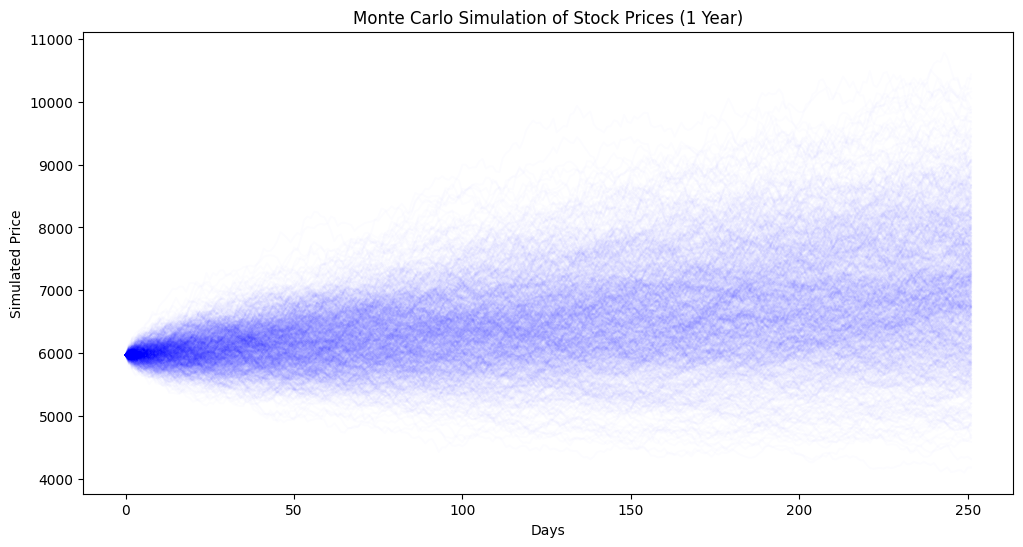

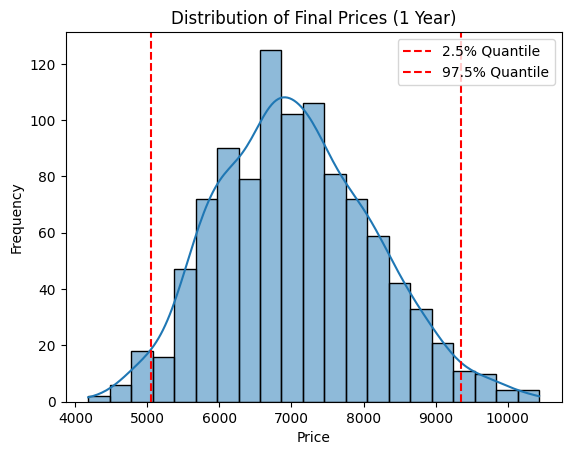

95% Confidence Interval: 5049.95 - 9358.58


In [33]:

# Automate with Functions

def monte_carlo_simulation(df, num_simulations=1000, num_days=252):
    mu = df['Log Return'].mean()
    sigma = df['Log Return'].std()
    last_price = df['Price'].iloc[-1]

    simulations = np.zeros((num_simulations, num_days))
    for i in range(num_simulations):
        prices = [last_price]
        for d in range(1, num_days):
            shock = np.random.normal(loc=mu, scale=sigma)
            price = prices[-1] * np.exp(shock)
            prices.append(price)
        simulations[i, :] = prices
    return simulations

def plot_simulations(simulations):
    plt.figure(figsize=(12,6))
    for i in range(simulations.shape[0]):
        plt.plot(simulations[i, :], color='blue', alpha=0.01)
    plt.title('Monte Carlo Simulation of Stock Prices (1 Year)')
    plt.xlabel('Days')
    plt.ylabel('Simulated Price')
    plt.show()

def plot_final_price_distribution(simulations):
    final_prices = simulations[:, -1]
    ci_lower = np.percentile(final_prices, 2.5)
    ci_upper = np.percentile(final_prices, 97.5)

    sns.histplot(final_prices, kde=True)
    plt.title('Distribution of Final Prices (1 Year)')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.axvline(ci_lower, color='red', linestyle='--', label='2.5% Quantile')
    plt.axvline(ci_upper, color='red', linestyle='--', label='97.5% Quantile')
    plt.legend()
    plt.show()

    print(f'95% Confidence Interval: {ci_lower:.2f} - {ci_upper:.2f}')

def run_monte_carlo_pipeline(data):
    simulations = monte_carlo_simulation(data)
    plot_simulations(simulations)
    plot_final_price_distribution(simulations)

# Use the already loaded and cleaned DataFrame 'df'
run_monte_carlo_pipeline(df)